## Imports and loading data

In [22]:
%pip install tensorflow_datasets
%pip install pickle



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import tensorflow as tf
import numpy as np
import pickle


In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    batch_size=-1,
    as_supervised=True,  # Include labels
    # shuffle_files=False,
    # with_info=True
)

size = (150, 150)

train_ds = tf.image.resize(train_ds, size)
test_ds = tf.image.resize(test_ds, size)


train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

2024-11-21 16:11:57.221908: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3488249856 exceeds 10% of free system memory.
2024-11-21 16:11:59.001338: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1494964224 exceeds 10% of free system memory.
2024-11-21 16:11:59.649523: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1546825728 exceeds 10% of free system memory.


In [25]:
# ds, ds_info = tfds.load('tf_flowers', split='train',shuffle_files=True, with_info=True)
# fig = tfds.show_examples(ds, ds_info)


## Preprocessing data

In [26]:
train_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [27]:
train_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [28]:
train_ds.shape

TensorShape([2569, 224, 224, 3])

## Loading VGG16 model

In [29]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

base_model = VGG16(
    weights="imagenet", include_top=False, 
    input_shape=train_ds[0].shape
)

base_model.trainable = False


In [30]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

 block3_conv3 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 28, 28, 256)       0         
                                                                 
 block4_conv1 (Conv2D)       (None, 28, 28, 512)       1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 14, 14, 512)       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 14, 14, 512)       2359808   
          

## Adding Layers

In [31]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

model = models.Sequential([
    base_model,   # vgg16 here
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
Total params: 15,970,263
Trainable params: 1,255,575
Non-trainable params: 14,714,688
_________________________________________________________________


## Training model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', patience=5,  
    restore_best_weights=True
)

history = model.fit(
    train_ds, train_labels, 
    epochs=50, 
    validation_split=0.2, 
    batch_size=32, 
    callbacks=[es]
)

model.save('model.h5')


with open('./trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)

2024-11-21 16:12:07.845245: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1237340160 exceeds 10% of free system memory.


Epoch 1/50


2024-11-21 16:12:10.555532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 16:12:10.656557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 16:12:10.656604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 16:12:10.656642: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-21 16:12:10.656659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

65/65 [==============================] - ETA: 0s - loss: 1.8794 - accuracy: 0.3382

2024-11-21 16:13:33.530476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 16:13:33.597985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 16:13:33.598030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 16:13:33.598062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-21 16:13:33.598076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

65/65 [==============================] - 108s 2s/step - loss: 1.8794 - accuracy: 0.3382 - val_loss: 1.4177 - val_accuracy: 0.4475
Epoch 2/50
65/65 [==============================] - 104s 2s/step - loss: 1.2683 - accuracy: 0.5324 - val_loss: 1.1777 - val_accuracy: 0.5642
Epoch 3/50
12/65 [====>.........................] - ETA: 1:11 - loss: 1.0132 - accuracy: 0.6328

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
model = tf.keras.models.load_model('model.h5')

history = {}
with open("./trainHistoryDict", 'rb') as file:
    history = pickle.load(file)


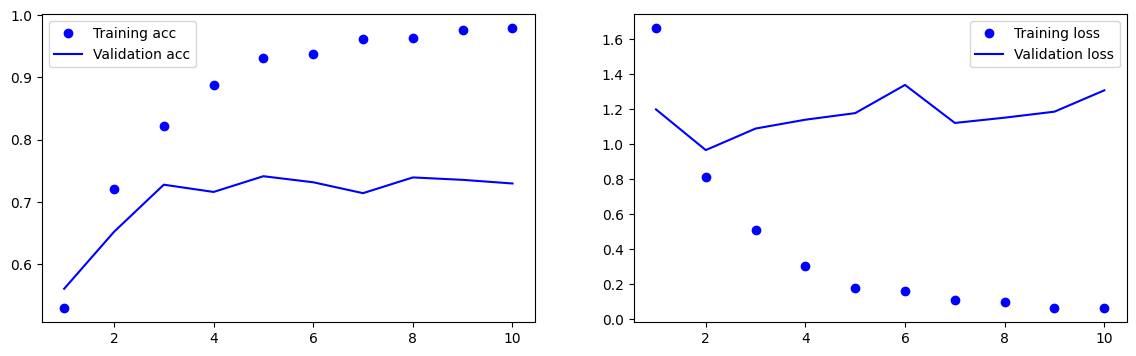

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model_2_val = val_acc[-1]
print("Validation Accuracy: ", model_2_val)

Validation Accuracy:  0.7295719981193542


In [ ]:
model.evaluate(test_ds, test_labels)

NameError: name 'test_ds' is not defined

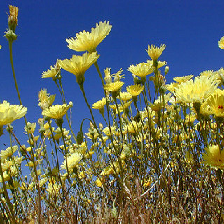

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/google_image_classification_example/img_dataset/flower_photos/daisy/5794835_d15905c7c8_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/google_image_classification_example/img_dataset/flower_photos/roses/102501987_3cdb8e5394_n.jpg"
sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/google_image_classification_example/img_dataset/flower_photos/dandelion/8684108_a85764b22d_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/google_image_classification_example/img_dataset/flower_photos/roses/102501987_3cdb8e5394_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/google_image_classification_example/img_dataset/flower_photos/roses/102501987_3cdb8e5394_n.jpg"

img = tf.keras.utils.load_img( sunflower_path, target_size=(224, 224))

img

In [ ]:
import keras.utils as image

#convert image to array
input_img = image.img_to_array(img)
input_img = np.expand_dims(input_img, axis=0)
# input_img

#Predict the inputs on the model
predict_img = model.predict(input_img )

data = np.array([['dandelion','daisy','tulips','sunflowers','roses'],predict_img[0]])

import pandas as pd

df = pd.DataFrame(data[1:], columns=data[0])

# Display the DataFrame as a table
df

1/1 [==============================] - 0s 125ms/step


2024-11-21 15:23:42.383230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


,dandelion,daisy,tulips,sunflowers,roses
0,3.1878875e-12,2.6615133e-29,0.76416785,0.23583223,4.0424212e-13
